In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
from collections import Counter
%matplotlib inline
# gpu_options = tf.GPUOptions(allow_growth=True)#, per_process_gpu_memory_fraction=0.1)
# s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))


C:\Users\Anton\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%time
import os
import keras
import keras.applications as zoo
from keras.activations import softmax
keras.backend.set_learning_phase(0)

model = zoo.MobileNet(include_top=True, weights='imagenet')

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Wall time: 6.63 s


In [3]:
inp = model.get_layer(index=0)
out = model.get_layer(name='conv_dw_4_relu').output
headless = keras.models.Model(inp.input, out)

In [4]:
for layer in model.layers:
    layer.trainable = False

In [5]:
del model

In [6]:
headless.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
def random_crop(image, answer, num=10, size_one=33, shape=(224, 224)):
    def one_hot(y_train):
        new_y = np.zeros((np.array(y_train.shape).prod(), ) + (5,))
        for i, y in zip(range(np.array(y_train.shape).prod()), y_train.reshape(-1)):
            new_y[i, y] = 1
        return new_y.reshape(-1, 224, 224, 5)

    img = []
    masks = []
    for i in range(num):
        random_indices = np.random.randint(0, image.shape[0], size_one)
        
        rand_x = np.random.randint(0, image.shape[2] - shape[0], size=image.shape[0])
        rand_y = np.random.randint(0, image.shape[1] - shape[1], size=image.shape[0])
        for i in range(size_one):
            x = slice(rand_x[i], rand_x[i] + shape[0])
            y = slice(rand_y[i], rand_y[i] + shape[1])
        img.append(image[random_indices, y, x])
        masks.append(answer[random_indices, y, x])
    masks = one_hot(np.array(masks))
    return np.array(img).reshape(-1, *shape, 3), masks

In [10]:
%%time

from PIL import Image, ImageFilter
real = sorted(os.listdir('./../../python/mirea_images/real_images/'))
seg = sorted(os.listdir('./../../python/mirea_images/sig_data/'))
images = []
answer = []
for i, j in zip(real, seg):
#     img = plt.imread("./mirea_images/real_images/{}".format(i))
    img = Image.open("./../../python/mirea_images/real_images/{}".format(i))
    
    img = img.filter(ImageFilter.MedianFilter(size=11))
    img = np.array(img)
    ans = plt.imread("./../../python/mirea_images/sig_data/{}".format(j))
    images.append(img)
    answer.append(ans)
    
answer = np.array(answer)[:,:,:,:-1:]
images = np.array(images)

color_to_i = {color:i for i,color in enumerate(set(map(tuple,answer.reshape([-1,3]))))}
i_to_color = {i:color for i,color in enumerate(set(map(tuple,answer.reshape([-1,3]))))}
def to_labels(pixels):
    pixels_flat = pixels.reshape([-1,3])
    classes_flat = list(map(color_to_i.get,map(tuple,pixels_flat)))
    return np.array(classes_flat).reshape(pixels.shape[:-1])
def to_ans(pred, shape):
    if pred.shape[-1] == 5:
        pred = np.argmax(pred, axis=-1)
    if pred.shape[1:3] != shape:
        pred = pred.reshape(-1, *shape)
    return np.array(list(map(list, map(i_to_color.get, pred.reshape(-1))))).reshape(*shape, 3)


answer = to_labels(answer)

Wall time: 1min 24s


In [11]:
%%time
a = np.arange(images.shape[0])
np.random.shuffle(a)
x_train, y_train = random_crop(images[a[:-6]], answer[a[:-6]], num=15, size_one=30)

x_test, y_test = random_crop(images[a[-6:]], answer[a[-6:]], num=10, size_one=2)

pred_tr = headless.predict(x_train/255.)
pred_te = headless.predict(x_test/255.)

Wall time: 23.3 s


In [12]:
def create_tree(pred, y):
    def create_mask(pred, y, ind=None):
#         if pred.shape[1:3] == (224, 224):
#             return y_train[:pred.sahpe[0]] if ind == None else y_train[ind]
#         else:
        print(pred.shape)
        y_true = []#np.zeros([pred.shape[0], 28, 28)
        #y_train = np.argmax(yt)
        
        for k in tqn(range(pred.shape[0])):
            for i in range(0, y.shape[1], 8):
                for j in range(0, y.shape[2], 8):
                    y_true.append(list(Counter(map(tuple, y[:,i:i+8,j:j+8:][k] \
                                                   .reshape([-1, 5]))).most_common(1)[0][0]))
                
        return np.argmax(np.array(y_true).reshape(pred.shape[0], -1, 5), axis=-1)
    pred = pred.reshape(pred.shape[0], -1, 128)
    return create_mask(pred, y)

In [13]:
train_to_tree = create_tree(pred_tr, y_train)
test_to_tree = create_tree(pred_te, y_test)

(450, 784, 128)


A Jupyter Widget


(20, 784, 128)


A Jupyter Widget

In [59]:
%%time
from sklearn.decomposition import pca
a = pca.PCA(n_components=50)
pca_train = a.fit_transform(X=pred_tr.reshape(-1, 128))
pca_test = a.fit_transform(X=pred_te.reshape(-1, 128))

Wall time: 5.7 s


In [14]:
%%time
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(pred_tr.reshape(-1, 128), train_to_tree.reshape(-1))
# pca_rf = RandomForestClassifier().fit(pca_train, train_to_tree.reshape(-1))

Wall time: 1min 36s


In [15]:
random_test_pred = rf.predict(pred_te.reshape(-1, 128))
# pca_test_pred =pca_rf.predict(pca_test.reshape(-1, 50))

In [67]:
len(np.where(pca_test_pred == test_to_tree.reshape(-1))[0]) / len(pca_test_pred)

0.7238520408163265

In [16]:
len(np.where(random_test_pred == test_to_tree.reshape(-1))[0])/len(random_test_pred)

0.9860969387755102

Without filters = 0.97%

GaussianFilter = 0.9846301020408164

BLUR = 0.9827168367346939

MEDIAN = 0.9920280612244898 (size = 11)

MEDIAN(size=11) + MAX(size3) = 0.9860331632653061

In [15]:
%%time
from sklearn.tree import DecisionTreeClassifier
fa = DecisionTreeClassifier(max_depth=10).fit(pred_tr.reshape(-1, 128), train_to_tree.reshape(-1))

Wall time: 1min 54s


In [15]:
%%time
# random_train_pred = rf.predict_proba(pred_tr.reshape(-1, 128))
random_test_pred = rf.predict(pred_te.reshape(-1, 128))
# random_test_pred = pca_rf.predict(pca_test)

Wall time: 42.6 ms


In [39]:
from sklearn.externals import joblib
# joblib.dump(rf, 'tr.pkl')
rf = joblib.load('tr.pkl')

### train

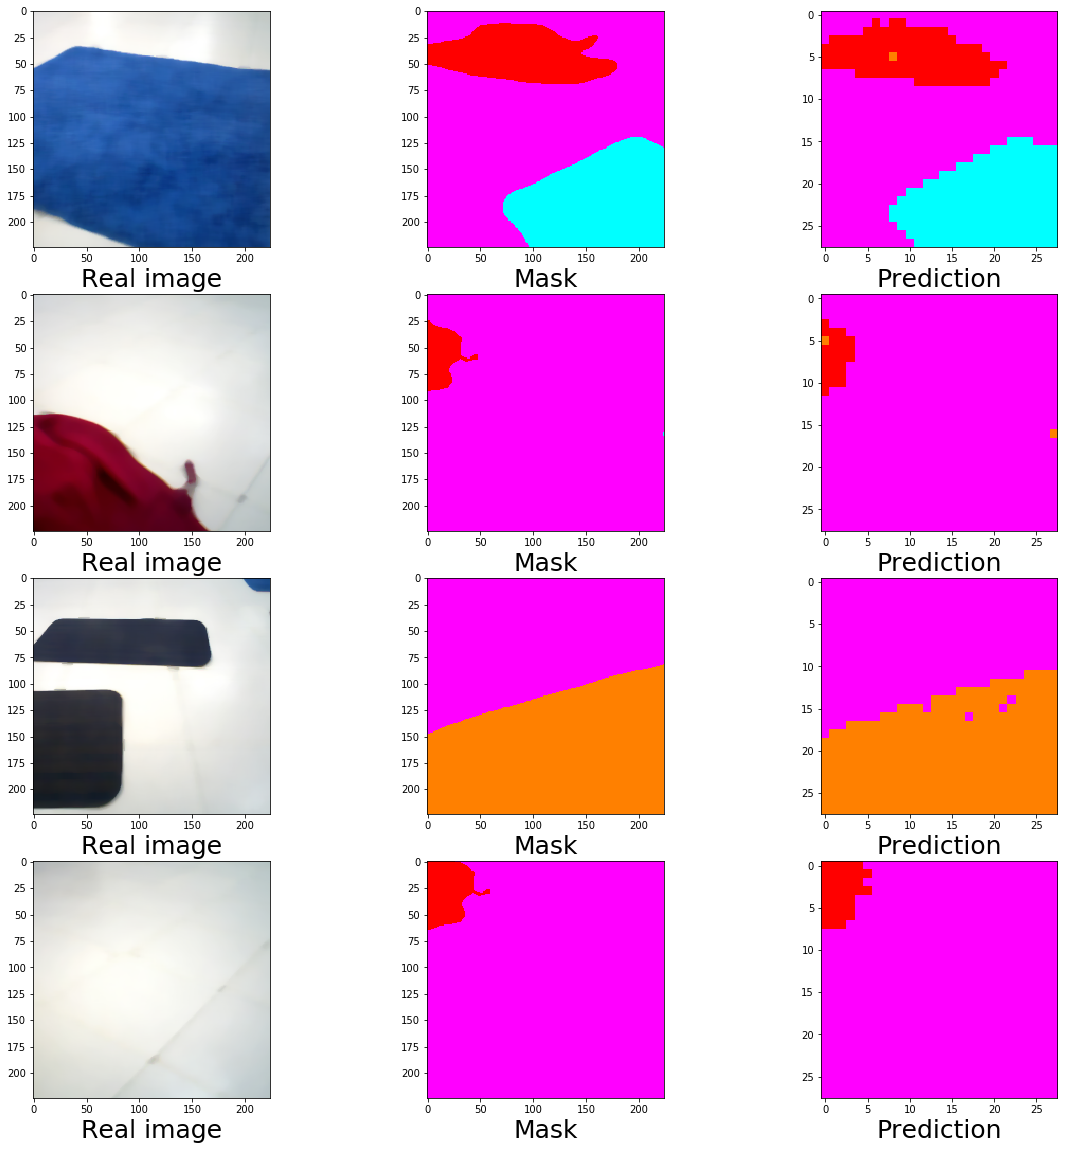

In [17]:
a = 0
_, ax = plt.subplots(4, 3, figsize=(20, 20))
ax = ax.reshape(-1)
for i in np.random.randint(0, len(x_test), 4):
    ax[a].imshow(x_train[i])
    ax[a].set_xlabel('Real image', fontsize=25)
    ax[a+1].imshow(to_ans(y_test[i], (224, 224)))
    ax[a+1].set_xlabel('Mask', fontsize=25)
    ax[a+2].imshow(to_ans(random_test_pred.reshape(20, -1)[i], (28, 28)))
    ax[a+2].set_xlabel('Prediction', fontsize=25)
    a += 3

###  test

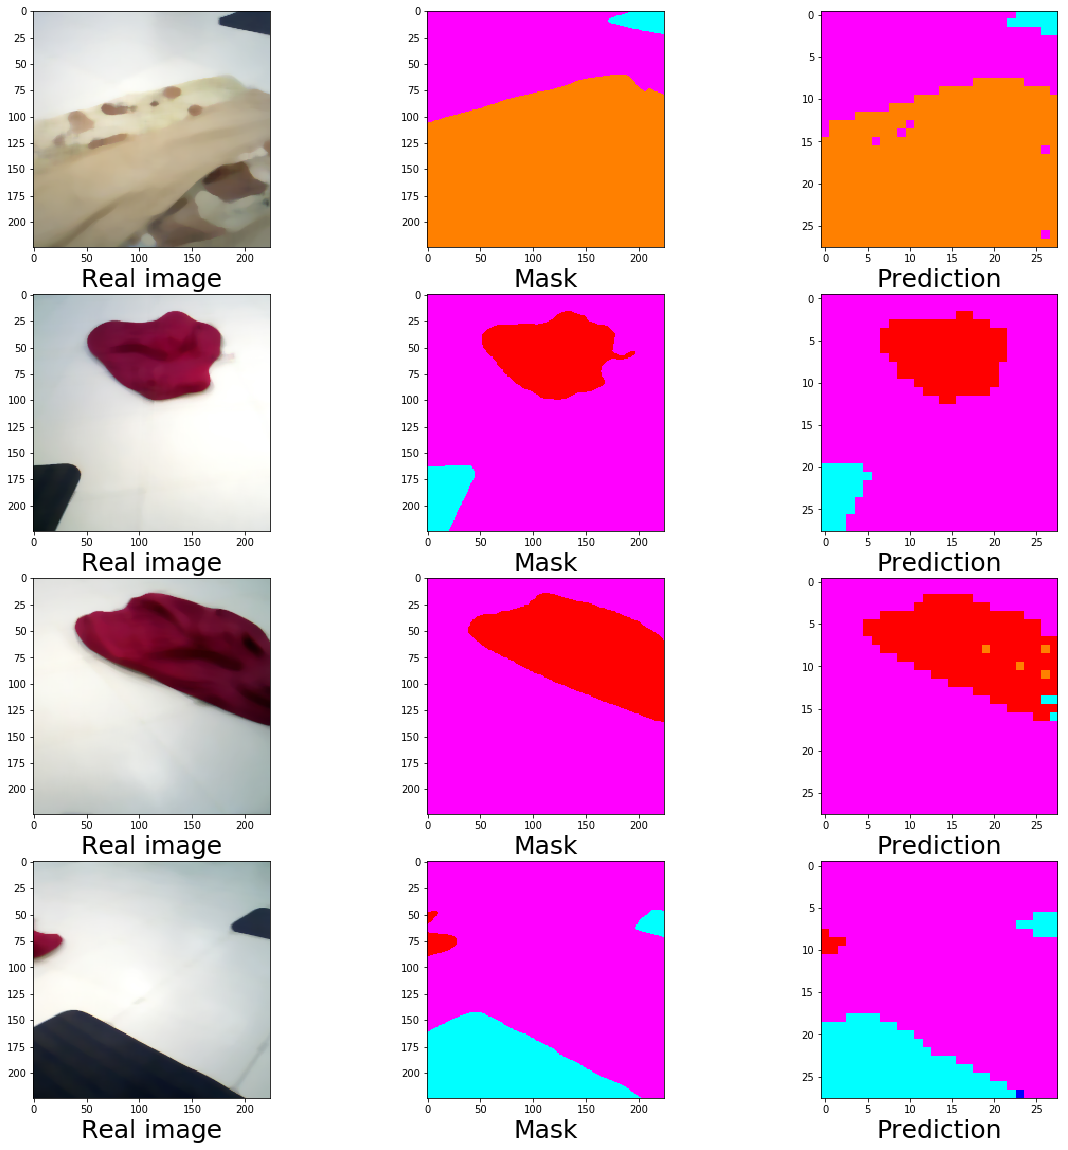

In [18]:
a = 0
_, ax = plt.subplots(4, 3, figsize=(20, 20))
ax = ax.reshape(-1)
for i in np.random.randint(0, len(x_test), 4):
    ax[a].imshow(x_test[i])
    ax[a].set_xlabel('Real image', fontsize=25)
    ax[a+1].imshow(to_ans(y_test[i], (224, 224)))
    ax[a+1].set_xlabel('Mask', fontsize=25)
    ax[a+2].imshow(to_ans(random_test_pred.reshape(20, -1)[i], (28, 28)))
    ax[a+2].set_xlabel('Prediction', fontsize=25)
    a += 3